In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import geopandas as gpd
import folium
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import pyspark
import numpy as np
from matplotlib.ticker import FixedLocator

In [2]:
# Reading in the taxi zone data and combining the data.
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
# Tute 2 Applied Data Science Tutorial Materials
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

In [3]:
# Reading in the hourly demand parquet and combining with zone data
hour_all = pd.read_parquet('../data/curated/hour_all/')
hour_all = pd.merge(hour_all, gdf, left_on='pulocationid', right_on='LocationID', how='inner')

### Fitting a Linear Regression Model

Using statsmodels to fit the hourly demand against the our weather data (borough, wind, rain, temp, snow and cloud).

In [4]:
# Fitting a model to predict the hourly demand based on the borough and all our weather variables
model = ols('demand ~ C(Borough) + wind + rain + temp + cloud',data=hour_all ).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                 1.679e+04
Date:                Sat, 19 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:24:31   Log-Likelihood:            -4.4637e+06
No. Observations:              791967   AIC:                         8.927e+06
Df Residuals:                  791958   BIC:                         8.928e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### ANOVA

Here we used the anova function from statsmodel to test if our variables are statistically significant.

In [5]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Borough),5.987447e+08,4.0,32512.317905,0.000000e+00
wind,5.615023e+06,1.0,1219.601006,5.364461e-267
rain,1.580579e+06,1.0,343.306753,1.261758e-76
temp,2.340470e+07,1.0,5083.576478,0.000000e+00
cloud,2.476259e+05,1.0,53.785151,2.238686e-13
Residual,3.646162e+09,791958.0,NaN,NaN


### Plotting the diagnostics

The code that is used to plot the diagnostic plots originates from https://www.statsmodels.org/devel/examples/notebooks/generated/linear_regression_diagnostics_plots.html

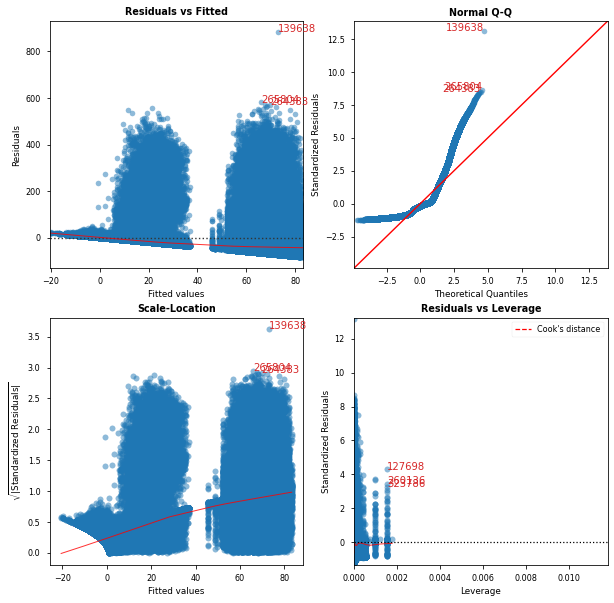

NameError: name 'pd' is not defined

In [10]:
import ipynb.fs.full.func as dg
# Plotting all the diagnostic plots.
# Note this takes a very very long time, not recommended to run. 
cls = dg.LinearRegDiagnostic(model)
vif, fig, ax = cls()
print(vif)

In [6]:
import ipynb.fs.full.func as dg
cls = dg.LinearRegDiagnostic(model)

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

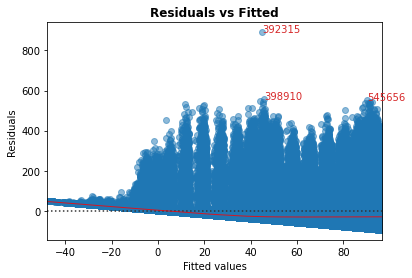

In [18]:

cls.residual_plot()

<AxesSubplot:title={'center':'Normal Q-Q'}, xlabel='Theoretical Quantiles', ylabel='Standardized Residuals'>

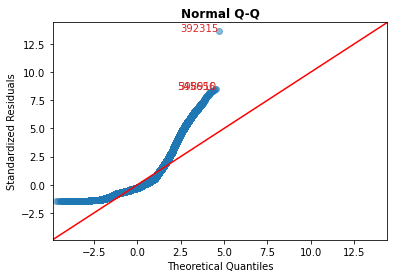

In [19]:
cls.qq_plot()

<Axes: title={'center': 'Scale-Location'}, xlabel='Fitted values', ylabel='$\\sqrt{|\\mathrm{Standardized\\ Residuals}|}$'>

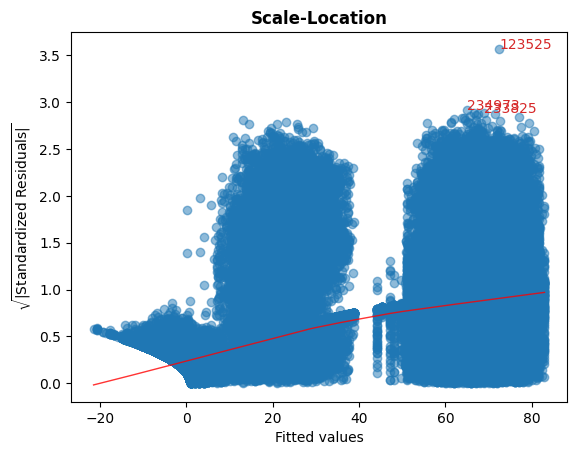

In [7]:

cls.scale_location_plot()

<AxesSubplot:title={'center':'Residuals vs Leverage'}, xlabel='Leverage', ylabel='Standardized Residuals'>

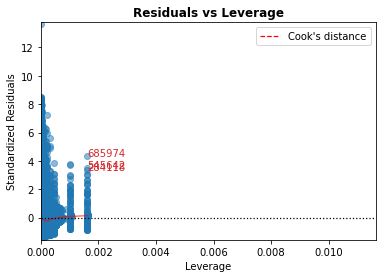

In [21]:
cls.leverage_plot()